In [1]:
import numpy as np
import os
from glob import glob
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import cv2
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

/misc/me/pratikm/virtualEnv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
tf.enable_eager_execution(device_policy=tfe.DEVICE_PLACEMENT_SILENT)

## Global Variables

In [3]:
DIR_TFRECORDS = 'data_VOC2012/VOC2012/data_voc2012_tfrecords'
DATA_TRAIN = glob('./'+DIR_TFRECORDS+'/*.tfrecords')
OBJECT_LABELS = {
    'tvmonitor': (0, 'Indoor'),
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle')
}
OBJECTS = ['tvmonitor', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 
          'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train']
NUM_OBJECTS = 20
MAX_DETECTIONS_PER_IMAGE = 10

GRID_H, GRID_W = 13, 13
GRID_SIZE = 416//GRID_H 

ANCHORS_NORMALIZED = np.array(
    [
        [0.05210654, 0.04405615],
        [0.15865615, 0.14418923],
        [0.42110308, 0.25680231],
        [0.27136769, 0.60637077],
        [0.70525231, 0.75157846]
    ]
)

ANCHORS = ANCHORS_NORMALIZED * np.array([GRID_H, GRID_W])
NUM_ANCHORS = ANCHORS.shape[0]

IMG_H, IMG_W = GRID_H * GRID_SIZE, GRID_W * GRID_SIZE

THRESHOLD_IOU_SCORES = 0.6
COEFF_LOSS_CONFIDENCE_OBJECT_PRESENT = 5
COEFF_LOSS_CONFIDENCE_OBJECT_ABSENT = 1
THRESHOLD_OUT_PROB = 0.5
THRESHOLD_IOU_NMS = 0.5

NUM_EPOCHS = 10 # not used
BATCH_SIZE = 16
CHECKPOINT_DIR = 'model'
CHECKPOINT_PREFIX = os.path.join(CHECKPOINT_DIR, "ckpt")
DIR_IMG_OUT = 'imgs_out'

## Utility

In [4]:
def parse_record(record):
    # dictionary as per saved TFRecord
    keys_to_features = {
        'img': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'label': tf.FixedLenFeature(shape=(), dtype=tf.string)
    }

    # parse record
    parsed = tf.parse_single_example(record, keys_to_features)

    # decode image
    img = tf.decode_raw(parsed['img'], tf.uint8)
    img = tf.cast(tf.reshape(img, [IMG_H, IMG_W, 3]), tf.float32)
    img /= 255.  # normalize

    # decode label
    label = tf.decode_raw(parsed['label'], tf.float32)
    label = tf.reshape(label, [GRID_H, GRID_W, NUM_ANCHORS, 6])
    
    return img, label

In [5]:
img_out = draw_output(img[0], output[0].numpy())
plt.imshow(img_out)

NameError: name 'draw_output' is not defined

In [ ]:
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

def draw_adjusted_anchor(img, idx_h, idx_w, idx_a, label_bbox):
    # box_adjustment.shape = [5,]
    
    center_y = (label_bbox[0]+idx_h)*GRID_SIZE
    center_x = (label_bbox[1]+idx_w)*GRID_SIZE
    
    height = label_bbox[2] * ANCHORS[idx_a,0] * GRID_SIZE
    width = label_bbox[3] * ANCHORS[idx_a,1] * GRID_SIZE
     
    left = int(center_x - width/2)
    top = int(center_y - height/2)
    right = int(left + width)
    bottom = int(top + height)

    img = cv2.rectangle(img, (left, top), (right, bottom), color=(0, 255, 0), thickness=3)
    
    return img
    
def label(img, label):
    # unnormalize image
    img = (img * 255).astype(np.uint8)
    
    for idx_h in range(GRID_H):
        for idx_w in range(GRID_W):
            for idx_a in range(NUM_ANCHORS):
                if sigmoid(label[idx_h, idx_w, idx_a, 5]) > 0.1:
                    bbox = label[idx_h, idx_w, idx_a, :4]
                    img = draw_adjusted_anchor(img, idx_h, idx_w, idx_a, bbox)
    
    return img

def draw_output(img, output):
    # unnormalize image
    img = (img * 255).astype(np.uint8)
    
    for idx_box in range(output.shape[0]):
        conf = output[idx_box][4]
        bbox = output[idx_box].astype(np.int32)
        obj_class = OBJECTS[bbox[5]]
        img = cv2.rectangle(img, (bbox[1], bbox[0]), (bbox[3], bbox[2]), color=(255, 0, 0), thickness=3)
        img = cv2.line(img, (bbox[1]+15, bbox[0]+15), (bbox[1]+15+150, bbox[0]+15), (255, 0, 0), 30, cv2.LINE_AA)
        font = cv2.FONT_HERSHEY_SIMPLEX
        img = cv2.putText(img, '{} ({:.2f})'.format(obj_class, conf),(bbox[1]+5, bbox[0]+20), font, .75,(255,255,255),2,cv2.LINE_AA)
        
        
    return img

def center2corner(predictions_yx, predictions_hw):
    # predictions_yx = [GRID_H, GRID_W, NUM_ANCHORS, 2]
    
    bbox_min = predictions_yx - (predictions_hw/2.)
    bbox_max = predictions_yx + (predictions_hw/2.)
    
    predictions_corner = tf.concat([bbox_min[...,0:1], bbox_min[...,1:2], bbox_max[...,0:1], bbox_max[...,1:2]], axis=-1)
    
    return predictions_corner

def get_filtered_predictions(predictions_corner, predictions_prob_obj, predictions_prob_class):
    # compute overall prob for each anchor in each grid
    predictions_prob = predictions_prob_obj * predictions_prob_class
    
    # get max prob among all classes at each anchor in each grid
    predictions_idx_class_max = tf.argmax(predictions_prob, axis=-1)
    predictions_prob = tf.reduce_max(predictions_prob, axis=-1)
    
    # compute filter mask
    mask_filter = predictions_prob >= THRESHOLD_OUT_PROB
    
    # apply mask on output
    bbox_filtered = tf.boolean_mask(predictions_corner, mask_filter)
    prob_filtered = tf.boolean_mask(predictions_prob, mask_filter)
    with tf.device('/cpu:0'):
        idx_class_filtered = tf.boolean_mask(predictions_idx_class_max, mask_filter)
    
    return bbox_filtered, prob_filtered, idx_class_filtered


def predictions2outputs(predictions):
    # apply corresponding transformations on predictions
    predictions_yx, predictions_hw, predictions_prob_obj, predictions_prob_class = apply_transformations(predictions)
    
    # map predictions_bbox to [0,1] space
    predictions_yx, predictions_hw = grid2normalized(predictions_yx, predictions_hw)
    
    # represent boxes using corners
    predictions_corner = center2corner(predictions_yx, predictions_hw)
    
    # filter predictions based on (prob_obj * prob_class). (needs to be done separately for each image in batch)
    bbox_filtered, prob_filtered, idx_class_filtered = get_filtered_predictions(predictions_corner, predictions_prob_obj, predictions_prob_class)
    # bbox_filtered.shape = [BATCH_SIZE, NUM_FILTERED, 4]
    
    # TODO: perform nms for each class separately
    # scale boxes from [0,1] to image space
    img_space = tf.reshape(tf.cast(tf.stack([IMG_H, IMG_W, IMG_H, IMG_W]), tf.float32), [1, 1, 4])
    bbox_filtered = tf.reshape(bbox_filtered*img_space, [-1, 4])  # tf.nms takes num_boxes (no batch support)
    
    # perform non-max suppression
    with tf.device('/cpu:0'):
        bbox_nms_indices = tf.image.non_max_suppression(bbox_filtered, tf.reshape(prob_filtered,[-1]), MAX_DETECTIONS_PER_IMAGE)
    bbox_nms = tf.gather(bbox_filtered, bbox_nms_indices)  # box_nms.shape = [len(bbox_nms_indices), 4]
    prob_nms = tf.expand_dims(tf.gather(prob_filtered, bbox_nms_indices), axis=-1) # prob_nms.shape = [len(bbox_nms_indices), 1]
    with tf.device('/cpu:0'):
        idx_class_nms = tf.expand_dims(tf.cast(tf.gather(idx_class_filtered, bbox_nms_indices), tf.float32), axis=-1)
    
    # concat return data
    output = tf.concat([bbox_nms, prob_nms, idx_class_nms], axis=-1)

    return tf.expand_dims(output, axis=0)

def process_label(label):
    label_class = tf.cast(label[..., 4], tf.int32)
    label_one_hot = tf.one_hot(label_class, NUM_OBJECTS)
    label_one_hot = tf.cast(label_one_hot, tf.float32)
    label_processed = tf.concat([label[...,0:4], label[5:6], label_one_hot])
    
    label_processed = predictions2outputs(label_processed)
    
    return label_processed

In [ ]:
def apply_transformations(predictions):
    predictions_yx = tf.sigmoid(predictions[..., 0:2])
    predictions_hw = tf.exp(predictions[...,2:4])
    predictions_prob_obj = tf.sigmoid(predictions[...,4:5])
    predictions_prob_class = tf.nn.softmax(predictions[...,5:])
    
    return predictions_yx, predictions_hw, predictions_prob_obj, predictions_prob_class

def get_coordinates(h, w):
    coordinates_y = tf.range(h)
    coordinates_x = tf.range(w)
    x, y = tf.meshgrid(coordinates_x, coordinates_y)
    coordinates = tf.stack([y, x], axis=-1)
    coordinates = tf.reshape(coordinates, [1, h, w, 1, 2])
    coordinates = tf.cast(coordinates, tf.float32)
    
    return coordinates

def grid2normalized(predictions_yx, predictions_hw):    
    # create cartesian coordinates on grid space
    coordinates = get_coordinates(GRID_H, GRID_W)
    
    # map from grid space to [0,19] space
    anchors = tf.cast(tf.reshape(ANCHORS, [1, 1, 1, ANCHORS.shape[0], 2]), dtype=tf.float32)  # [0,19] space
    predictions_yx += coordinates
    predictions_hw *= anchors
    
    # map from [0,19] space to [0,1] space
    shape = tf.cast(tf.reshape([GRID_H, GRID_W], [1, 1, 1, 1, 2]), tf.float32)
    predictions_yx /= shape
    predictions_hw /= shape
    
    return predictions_yx, predictions_hw

def get_boxes_gt(args_map):
    # extract ground truth bboxes wherever prob_obj = 1
    mask_object = tf.cast(tf.reshape(args_map[1], [GRID_H, GRID_W, NUM_ANCHORS]), tf.bool)
    bboxes = tf.boolean_mask(args_map[0], mask_object)
    # bboxes.shape = [NUM_DETECTIONS, 4]; NUM_DETECTIONS vary with each image
    
    # pad bboxes so that bboxes is fixed dimension (fix NUM_DETECTIONS to MAX_DETECTIONS_PER_IMAGE)
    pad = tf.zeros((MAX_DETECTIONS_PER_IMAGE - tf.shape(bboxes)[0], 4))  # TODO: when NUM_DETECTIONS > MAX_DETECTIONS_PER_IMAGE
    bboxes = tf.concat([bboxes, pad], axis=0)
    
    return bboxes

def get_iou_scores(predictions_yx, predictions_hw, bboxes_gt):
    # predictions_yx.shape = predictions_hw.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 2]
    # bboxes_gt.shape = [BATCH_SIZE, MAX_DETECTIONS_PER_IMAGE, 4]
    
    # compute ious for each anchor in each grid in axis=4
    predictions_yx = tf.expand_dims(predictions_yx, 4)
    predictions_hw = tf.expand_dims(predictions_hw, 4)
    
    predictions_min = predictions_yx - predictions_hw/2.
    predictions_max = predictions_yx + predictions_hw/2.
    
    bboxes_gt = tf.reshape(bboxes_gt, [tf.shape(bboxes_gt)[0], 1, 1, 1, MAX_DETECTIONS_PER_IMAGE, 4])
    bboxes_gt_yx = bboxes_gt[..., 0:2]
    bboxes_gt_hw = bboxes_gt[..., 2:4]
    
    bboxes_gt_min = bboxes_gt_yx - bboxes_gt_hw/2.
    bboxes_gt_max = bboxes_gt_yx + bboxes_gt_hw/2.
    
    intersection_min = tf.maximum(predictions_min, bboxes_gt_min)
    intersection_max = tf.minimum(predictions_max, bboxes_gt_max)
    intersection_hw = tf.maximum(intersection_max - intersection_min, 0.)
    area_intersection = intersection_hw[..., 0] * intersection_hw[..., 1]
    
    area_predictions = predictions_hw[...,0] * predictions_hw[...,1]
    area_bboxes_gt = bboxes_gt_hw[...,0] * bboxes_gt_hw[...,1]
    area_union = area_bboxes_gt + area_predictions - area_intersection
    iou = area_intersection / area_union
    
    return iou

def get_confidence_loss(labels_prob_obj, iou_mask, predictions_prob_obj):
    mask_object_absent = (1 - labels_prob_obj) * (1 - iou_mask)
    loss_object_absent = mask_object_absent * tf.square(predictions_prob_obj)
    
    loss_object_present = labels_prob_obj * tf.square(1-predictions_prob_obj)
    
    loss_confidence = COEFF_LOSS_CONFIDENCE_OBJECT_ABSENT * loss_object_absent \
            + COEFF_LOSS_CONFIDENCE_OBJECT_PRESENT * loss_object_present
    
    return tf.reduce_sum(loss_confidence)
    
def get_classification_loss(labels_prob_obj, labels_class, predictions_prob_class):
    labels_class = tf.cast(labels_class, tf.int32)
    labels_class = tf.one_hot(labels_class, NUM_OBJECTS)
    
    loss_classification = labels_prob_obj * tf.squared_difference(labels_class, predictions_prob_class)
    
    return tf.reduce_sum(loss_classification)

def get_regression_loss(labels_bbox, predictions_bbox, labels_prob_obj):
    loss_regression = labels_prob_obj * tf.squared_difference(labels_bbox,predictions_bbox)
    
    return tf.reduce_sum(loss_regression)

In [ ]:
def get_iou(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box
    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]
    Returns:
        float: value of the IoU for the two boxes.
    Raises:
        AssertionError: if the box is obviously malformed
    """
    y1_t, x1_t, y2_t, x2_t, _, _ = gt_box
    y1_p, x1_p, y2_p, x2_p, _, _ = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou

    

def get_metrics(output, gt):
    # output.shape = gt.shape = [MAX_DETECTIONS_PER_IMAGE, 6]
    # returns tp, fp, fn
    # tp.shape = [NUM_THRESHOLDS, NUM_OBJECTS]
    
    tp, fp, fn = np.zeros([3, NUM_THRESHOLDS, NUM_OBJECTS])
    
    outputs_per_class = [[]] * NUM_OBJECTS
    for idx in range(len(NUM_OBJECTS)):
        elem_class = output[idx][5]
        outputs_per_class[ elem_class ].append( output[idx] )
    
    gt_per_class = [[]] * NUM_OBJECTS
    for idx in range(len(NUM_OBJECTS)):
        elem_class = [idx][5]
        gt_per_class[ elem_class ].append( gt[idx] )
    
    for threshold in np.linspace(0.5, 0.95, NUM_THRESHOLDS):
        for idx_class in range(NUM_OBJECTS):
            for out_elem in outputs_per_class[idx_class] :
                for gt_elem in gt_per_class[idx_class] :
                    x = get_iou( out_elem, gt_elem )
                    if x >= threshold :
                        
    

## Model

In [8]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.optimizer = tf.train.AdamOptimizer()
        
        # add layers
        self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', use_bias=False)
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D()

        self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', use_bias=False)
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.pool2 = tf.keras.layers.MaxPool2D()
        
        self.conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', use_bias=False)
        self.norm3 = tf.keras.layers.BatchNormalization()
        
        self.conv4 = tf.keras.layers.Conv2D(64, 1, padding='same', use_bias=False)
        self.norm4 = tf.keras.layers.BatchNormalization()
        
        self.conv5 = tf.keras.layers.Conv2D(128, 3, padding='same', use_bias=False)
        self.norm5 = tf.keras.layers.BatchNormalization()
        self.pool5 = tf.keras.layers.MaxPool2D()
        
        self.conv6 = tf.keras.layers.Conv2D(256, 3, padding='same', use_bias=False)
        self.norm6 = tf.keras.layers.BatchNormalization()
        
        self.conv7 = tf.keras.layers.Conv2D(128, 1, padding='same', use_bias=False)
        self.norm7 = tf.keras.layers.BatchNormalization()
        
        self.conv8 = tf.keras.layers.Conv2D(256, 3, padding='same', use_bias=False)
        self.norm8 = tf.keras.layers.BatchNormalization()
        self.pool8 = tf.keras.layers.MaxPool2D()
        
        self.conv9 = tf.keras.layers.Conv2D(512, 3, padding='same', use_bias=False)
        self.norm9 = tf.keras.layers.BatchNormalization()
        
        self.conv10 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)
        self.norm10 = tf.keras.layers.BatchNormalization()
        
        self.conv11 = tf.keras.layers.Conv2D(512, 3, padding='same', use_bias=False)
        self.norm11 = tf.keras.layers.BatchNormalization()
        
        self.conv12 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)
        self.norm12 = tf.keras.layers.BatchNormalization()
        
        self.conv13 = tf.keras.layers.Conv2D(512, 3, padding='same', use_bias=False)
        self.norm13 = tf.keras.layers.BatchNormalization()  # skip after this
        self.pool13 = tf.keras.layers.MaxPool2D()
        
        self.conv14 = tf.keras.layers.Conv2D(1024, 3, padding='same', use_bias=False)
        self.norm14 = tf.keras.layers.BatchNormalization()
        
        self.conv15 = tf.keras.layers.Conv2D(512, 1, padding='same', use_bias=False)
        self.norm15 = tf.keras.layers.BatchNormalization()
        
        self.conv16 = tf.keras.layers.Conv2D(1024, 3, padding='same', use_bias=False)
        self.norm16 = tf.keras.layers.BatchNormalization()
        
        self.conv17 = tf.keras.layers.Conv2D(512, 1, padding='same', use_bias=False)
        self.norm17 = tf.keras.layers.BatchNormalization()
        
        self.conv18 = tf.keras.layers.Conv2D(1024, 3, padding='same', use_bias=False)
        self.norm18 = tf.keras.layers.BatchNormalization()
        
        self.conv19 = tf.keras.layers.Conv2D(1024, 3, padding='same', use_bias=False)
        self.norm19 = tf.keras.layers.BatchNormalization()
        
        self.conv20 = tf.keras.layers.Conv2D(1024, 3, padding='same', use_bias=False)
        self.norm20 = tf.keras.layers.BatchNormalization()
        
        self.conv21 = tf.keras.layers.Conv2D(64, 1, padding='same', use_bias=False)  # apply on skipped connection
        self.norm21 = tf.keras.layers.BatchNormalization()
        
        self.conv22 = tf.keras.layers.Conv2D(1024, 3, padding='same', use_bias=False)
        self.norm22 = tf.keras.layers.BatchNormalization()
        # Feature Extractor Ends Here!
        
        # Detector Layer!
        self.conv23 = tf.keras.layers.Conv2D(NUM_ANCHORS*(4+1+NUM_OBJECTS), 1, padding='same')
    
    def load_pretrained_weights(self, dir_weights):
        for idx_layer, layer in enumerate(self.layers):
            filename = dir_weights + '/' + str(idx_layer)
            with open(filename, 'rb') as file:
                weights = pickle.load(file)
            
            layer.set_weights(weights)
        
        print('Weights loaded.')
        
    def forward(self, imgs):
        # imgs.shape = [B, IMG_H, IMG_W, 3]
        
        # for now, resize and reshape imgs to vector
        imgs = tf.image.resize_images(imgs, [416, 416])
        
        x = self.conv1(imgs)
        x = self.norm1(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.norm3(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv4(x)
        x = self.norm4(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv5(x)
        x = self.norm5(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        x = self.pool5(x)
        
        x = self.conv6(x)
        x = self.norm6(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv7(x)
        x = self.norm7(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv8(x)
        x = self.norm8(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        x = self.pool8(x)
        
        x = self.conv9(x)
        x = self.norm9(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv10(x)
        x = self.norm10(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv11(x)
        x = self.norm11(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv12(x)
        x = self.norm12(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv13(x)
        x = self.norm13(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        x_skip = tf.identity(x)
        x = self.pool13(x)
        
        x = self.conv14(x)
        x = self.norm14(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv15(x)
        x = self.norm15(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv16(x)
        x = self.norm16(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv17(x)
        x = self.norm17(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv18(x)
        x = self.norm18(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv19(x)
        x = self.norm19(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x = self.conv20(x)
        x = self.norm20(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        
        x_skip = self.conv21(x_skip)
        x_skip = self.norm21(x_skip)
        x_skip = tf.nn.leaky_relu(x_skip, alpha=0.1)
        x_skip = tf.space_to_depth(x_skip, block_size=2)  # lossless shrinkage of feature map
        
        x = tf.concat([x_skip, x], axis=-1)  # low_level features concatenated with high_level features
        
        x = self.conv22(x)
        x = self.norm22(x)
        x = tf.nn.leaky_relu(x, alpha=0.1)
        # Feature Extractor ends here!
        
        # Detector layer
        x = self.conv23(x)
        
        # reshape output
        pred = tf.reshape(x, [-1, GRID_H, GRID_W, NUM_ANCHORS, 4+1+NUM_OBJECTS])
        
        return pred
    
    def get_loss(self, predictions, labels):
        # predictions.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 5+NUM_OBJECTS] (they are in grid space)
        # labels.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 6]

        # apply corresponding transformations on predictions
        predictions_yx, predictions_hw, predictions_prob_obj, predictions_prob_class = apply_transformations(predictions)

        # map predictions_bbox to [0,1] space
        predictions_yx, predictions_hw = grid2normalized(predictions_yx, predictions_hw)

        # map labels_bbox to [0,1] space
        labels_yx, labels_hw = grid2normalized(labels[...,0:2], labels[...,2:4])

        # get ground truth bboxes using labels_bbox & prob_obj in labels
        labels_bbox = tf.concat([labels_yx, labels_hw], axis=-1)
        bboxes_gt = tf.map_fn(get_boxes_gt, (labels_bbox, labels[...,5]), dtype=tf.float32)

        # compute iou scores for each anchor in each grid for all bboxes_gt
        iou_scores = get_iou_scores(predictions_yx, predictions_hw, bboxes_gt)

        # keep anchors whose iou_scores are above THRESHOLD_IOU_SCORES
        iou_scores_best = tf.reduce_max(iou_scores, axis=4, keep_dims=True)
        iou_mask = tf.cast(iou_scores_best > THRESHOLD_IOU_SCORES, tf.float32)

        ## Loss
        # object confidence loss (presence and absence)
        loss_confidence = get_confidence_loss(labels[...,5:6], iou_mask, predictions_prob_obj)

        # classification loss
        loss_classification = get_classification_loss(labels[...,5:6], labels[...,4], predictions_prob_class)

        # regression loss
        predictions_bbox = tf.concat([predictions_yx, predictions_hw], axis=-1)
        loss_regression = get_regression_loss(labels_bbox, predictions_bbox, labels[...,5:6])

        # total loss
        loss = ( loss_confidence + loss_classification + loss_regression ) / tf.cast(tf.shape(labels)[0], tf.float32)

        return loss
    
    def train(self, dataset):
        '''trains the model for one epoch'''
        epoch_loss = tf.constant(0.)
        for idx_batch, data in enumerate(tfe.Iterator(dataset)):
            with tfe.GradientTape() as tape:
                # forward pass
                predictions = self.forward(data[0])
                
                # reverse x & y axis
                predictions = tf.concat([predictions[...,1::-1], predictions[...,3:1:-1], predictions[...,4:]], axis=-1)
        
                # compute loss
                loss = self.get_loss(predictions, data[1])
                
            # backward pass (compute gradients)
            gradients = tape.gradient(loss, self.variables)
            
            # update parameters
            self.optimizer.apply_gradients(
                zip(gradients, self.variables), 
                global_step=tf.train.get_or_create_global_step()
            )
            
            epoch_loss += loss
            print('Batch:', idx_batch, '| Loss=', loss.numpy(), '\t', end='\r')
            
        return (epoch_loss/(idx_batch+1)).numpy()
        
    # ensure batch size is 1
    def evaluate(self, dataset):
        tps, fps, fns = np.zeros([3, NUM_THRESHOLDS, NUM_OBJECTS])
        for idx_batch, data in enumerate(tfe.Iterator(dataset)):
            # forward pass
            predictions = self.forward(data[0])

            # reverse x & y axis
            predictions = tf.concat([predictions[...,1::-1], predictions[...,3:1:-1], predictions[...,4:]], axis=-1)
            
            # post-process to get bounding boxes
            outputs = predictions2outputs(predictions)
            
            # process label
            gt = process_label(data[1])
            
            # compute tp, fp, fn
            tp, fp, fn = get_metrics(gt.numpy(), outputs.numpy())
            # tp.shape = [NUM_THRESHOLDS, NUM_OBJECTS]
            
            tps += tp
            fps += fp
            fns += fn
        
        
        # compute
        APs = get_AP(tps, fps, fns)
        # APs.shape = [NUM_OBJECTS, ]
        
        mAP = np.mean(APs)
        
        return mAP
        
        
            
        
    def predict(self, imgs):
        '''predicts bboxes and draws them on the image'''
        # imgs.shape = [B, IMG_H, IMG_W, 3]
        
        # forward pass
        predictions = self.forward(imgs)
        
        predictions = tf.concat([predictions[...,1::-1], predictions[...,3:1:-1], predictions[...,4:]], axis=-1)
        
        # post-process to get bounding boxes
        outputs = predictions2outputs(predictions)  
        # CAUTION!!!
        # TODO: use batch multi-class nms (currently works with BATCH_SIZE=1)
        # reference: https://github.com/tensorflow/models/blob/master/research/object_detection/core/post_processing.py
        
        return outputs

## Train

In [ ]:
# dataset processing
BATCH_SIZE = 16
dataset_train = tf.data.TFRecordDataset(DATA_TRAIN)
dataset_train = dataset_train.map(parse_record)
dataset_train = dataset_train.shuffle(buffer_size=1024)
dataset_train = dataset_train.batch(BATCH_SIZE)

In [9]:
with tf.device('/gpu:0'):
    model = Model()
    #model.train(dataset_train)
    #model.load_pretrained_weights('weights_YOLO')
    checkpoint = tfe.Checkpoint(model=model, optimizer_step=tf.train.get_or_create_global_step())
    checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))

In [ ]:
BATCH_SIZE = 16
with tf.device('/gpu:0'):
    model.optimizer = tf.train.AdamOptimizer(1e-6)
    for i in tqdm_notebook(range(100)):
        loss = model.train(dataset_train)
        print('Epoch:{} | Loss={}'.format(i, loss))
        
        if i % 10 == 0:
            # save checkpoint
            checkpoint.save(file_prefix=CHECKPOINT_PREFIX)
            print('checkpoint saved.')

## Prediction

In [11]:
# dataset processing
dataset_test = tf.data.TFRecordDataset(DATA_TRAIN)
dataset_test = dataset_test.map(parse_record)
dataset_test = dataset_test.shuffle(1024)
dataset_test = dataset_test.batch(1)

In [38]:
# test on data
with tf.device('/gpu:0'):
    # load trained model
    checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))
    
    for idx_img, data in enumerate(tfe.Iterator(dataset_test)):
        # predict
        output = model.predict(data[0])
        
        # write images
        img_out = draw_output(data[0][0].numpy(), output[0].numpy())
        cv2.imwrite(DIR_IMG_OUT+ '/'+str(idx_img)+'.png', cv2.cvtColor(img_out, cv2.COLOR_RGB2BGR))
        
        if idx_img > 100:
            break
#         img = imgs_out.numpy()[0]
#         img = (img * 255).astype(np.uint8)
#         cv2.imwrite(DIR_IMG_OUT+ '/'+str(idx_img)+'.png', img)

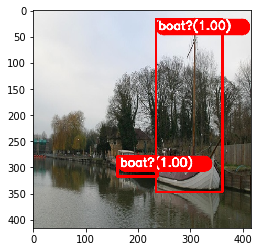

In [83]:
# prediction on images
def process_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_W, IMG_H))
    img = (img / 255.).astype(np.float32)
    img = np.expand_dims(img, 0)
    
    return img

DIR_IMGS = 'test_input'
DIR_IMGS_OUT = 'test_output'
if not os.path.exists(DIR_IMGS_OUT):
    os.makedirs(DIR_IMGS_OUT)
with tf.device('/gpu:0'):
    # load trained model
    checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))
    
    filenames = sorted(os.listdir(DIR_IMGS))
    for filename in filenames:
        path = os.path.join(DIR_IMGS, filenames[60])
        
        img = cv2.imread(path)
        img = process_img(img)
        
        output = model.predict(img)

        # write images
        img_out = draw_output(img[0], output[0].numpy())
        plt.imshow(img_out)
        break
        cv2.imwrite(DIR_IMGS_OUT+ '/'+filename, cv2.cvtColor(img_out, cv2.COLOR_RGB2BGR))
        

TypeError: integer argument expected, got float